## Análisis preliminar: asunciones básicas sobre los datos

Antes de abordar un enfoque funcional, estudiamos algunas hipótesis iniciales sobre el comportamiento de los datos:

- **¿Cuánto aumenta a la evaluación media el hacer trampas?**  
  - ¿Es proporcional a la cantidad de movimientos tramposos?

- **¿Hacer trampas acorta la duración de las partidas?**  
  - ¿En cuánto se reduce la duración promedio?  
  - ¿Existe una relación proporcional con la cantidad de movimientos tramposos?

- **¿Cuánto de más precisos son los movimientos tramposos respecto a los normales?**


In [1]:
import pickle
evals = pickle.load(open("evals.pkl", "rb"))
cheating_pos = pickle.load(open("cheating_pos.pkl", "rb"))
cheating_magnitude = pickle.load(open("cheating_magnitude.pkl", "rb"))

In [1]:
import pandas as pd
import skfda 
import numpy as np
import matplotlib.pyplot as plt

X = np.load('X.npy')
y = np.load('y.npy')

In [2]:
X_func = skfda.FDataGrid(X, grid_points=np.linspace(0, 1, 150))


np.True_

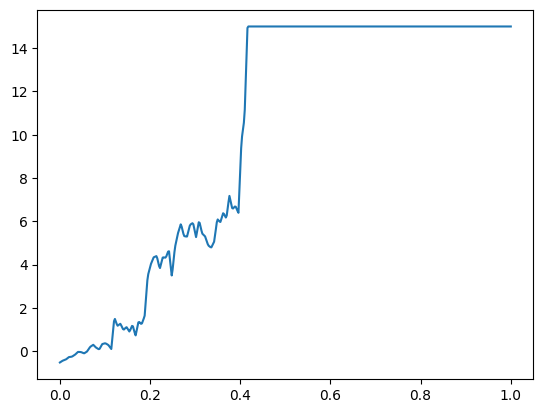

In [30]:
X_func[12000].plot()
y[12000]

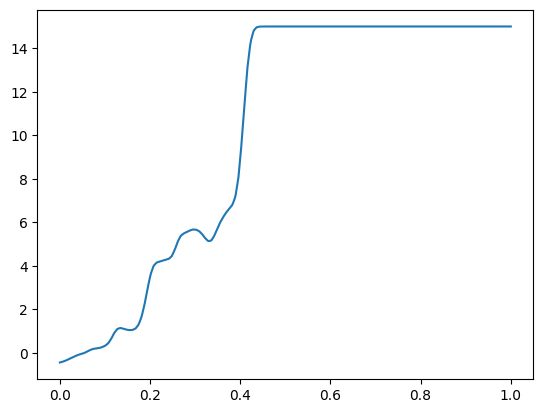

In [ ]:
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
from skfda.preprocessing.smoothing.validation import  LinearSmootherGeneralizedCVScorer
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother

# Defining grid search
bandwidth = np.linspace(0.01, 1, 100)


# Nadaraya-Watson kernel smoother
nw = SmoothingParameterSearch(
    KernelSmoother(kernel_estimator=NadarayaWatsonHatMatrix()),
    bandwidth,
    scoring=LinearSmootherGeneralizedCVScorer(penalization_function=lambda t:1),
    param_name='kernel_estimator__bandwidth'
)


nw.fit(X_func)
x_opt = nw.transform(X_func)



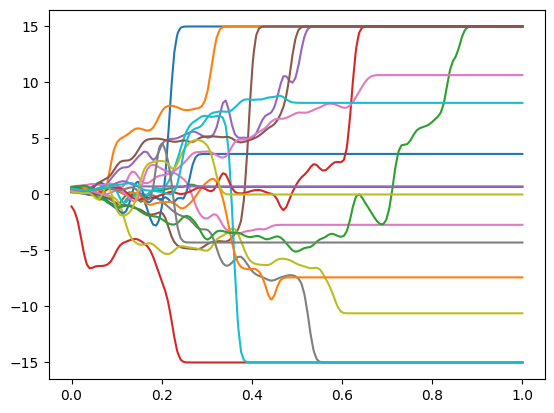

In [ ]:

fig = x_opt[:20].plot()


plt.show()

np.False_

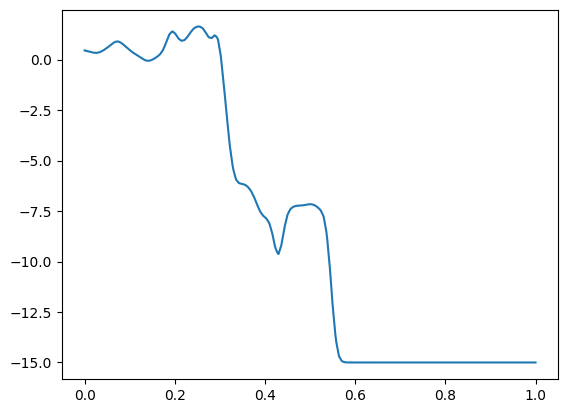

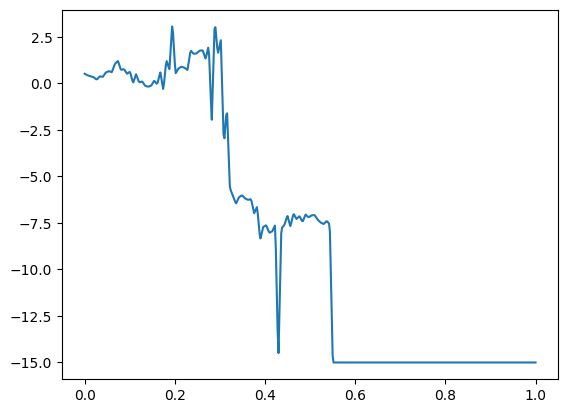

In [4]:
i = 800
x_opt[i].plot()
X_func[i].plot()
y[i]

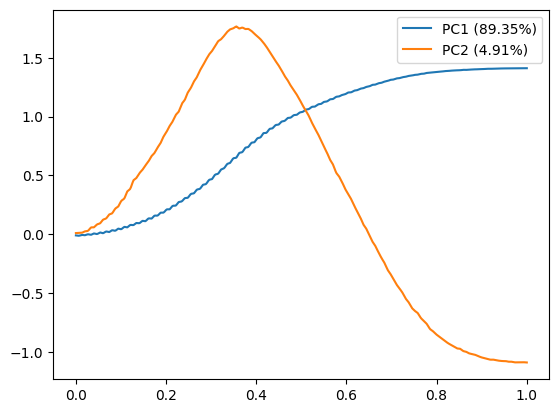

In [4]:
from skfda.preprocessing.dim_reduction import FPCA

fpca = FPCA(n_components=2)   # Definition of FPCA object
fpca.fit(X_func)             # Estimation of the principal components
fpca.components_.plot()

# Adding explained variance to the legend
explained_variance = fpca.explained_variance_ratio_ * 100
plt.legend([f'PC1 ({explained_variance[0]:.2f}%)', f'PC2 ({explained_variance[1]:.2f}%)'])
plt.show()

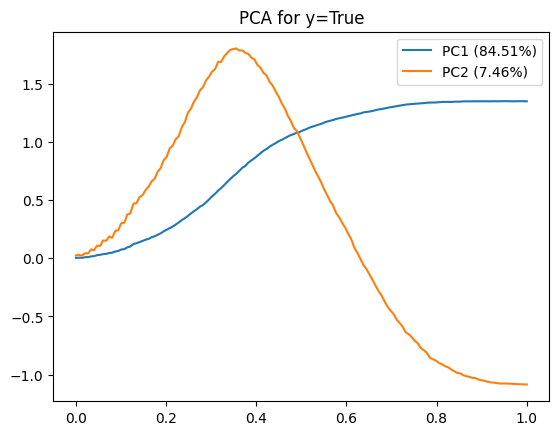

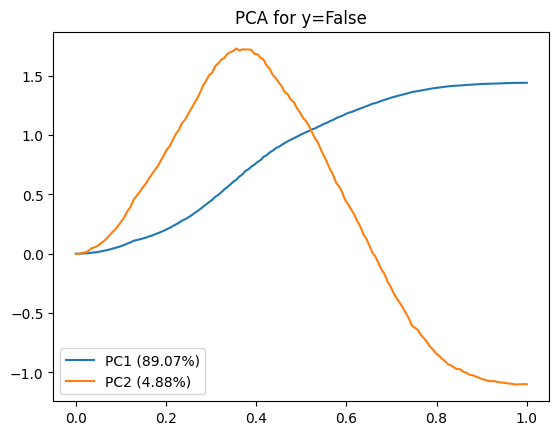

In [5]:
# Filter data based on labels
X_func_true = X_func[y]
X_func_false = X_func[~y]

# Perform PCA for y=True
fpca_true = FPCA(n_components=2)
fpca_true.fit(X_func_true)
fpca_true.components_.plot()
explained_variance_true = fpca_true.explained_variance_ratio_ * 100
plt.legend([f'PC1 ({explained_variance_true[0]:.2f}%)', f'PC2 ({explained_variance_true[1]:.2f}%)'])
plt.title("PCA for y=True")
plt.show()

# Perform PCA for y=False
fpca_false = FPCA(n_components=2)
fpca_false.fit(X_func_false)
fpca_false.components_.plot()
explained_variance_false = fpca_false.explained_variance_ratio_ * 100
plt.legend([f'PC1 ({explained_variance_false[0]:.2f}%)', f'PC2 ({explained_variance_false[1]:.2f}%)'])
plt.title("PCA for y=False")
plt.show()

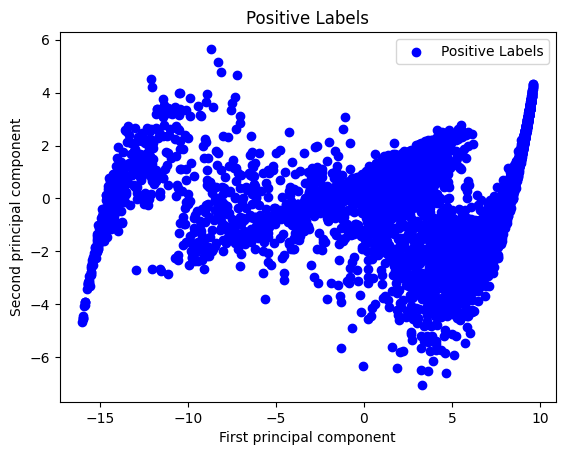

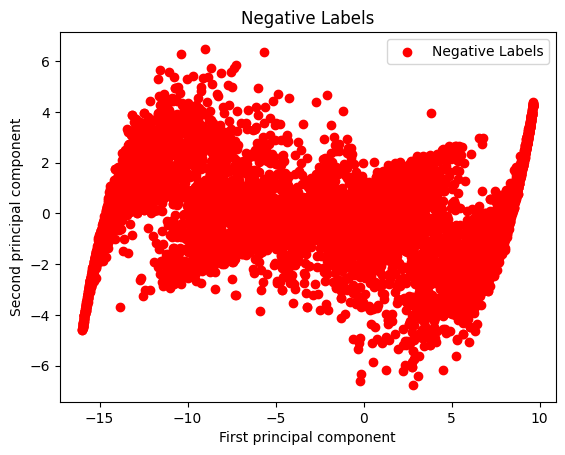

In [6]:
X_red = fpca.transform(x_opt) #Pojection
# Determine colors based on labels
colors = ['blue' if label else 'red' for label in y]


# Separate the data based on labels
X_red_positive = X_red[y]
X_red_negative = X_red[~y]

# Plot the points for positive labels
fig, ax = plt.subplots(1, 1)
ax.scatter(X_red_positive[:, 0], X_red_positive[:, 1], c='blue', label='Positive Labels')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_title('Positive Labels')
ax.legend()
plt.show()

# Plot the points for negative labels
fig, ax = plt.subplots(1, 1)
ax.scatter(X_red_negative[:, 0], X_red_negative[:, 1], c='red', label='Negative Labels')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_title('Negative Labels')
ax.legend()
plt.show()

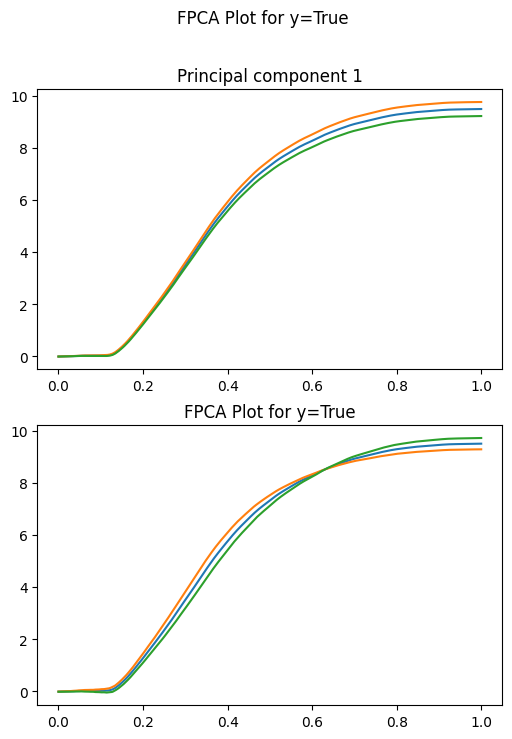

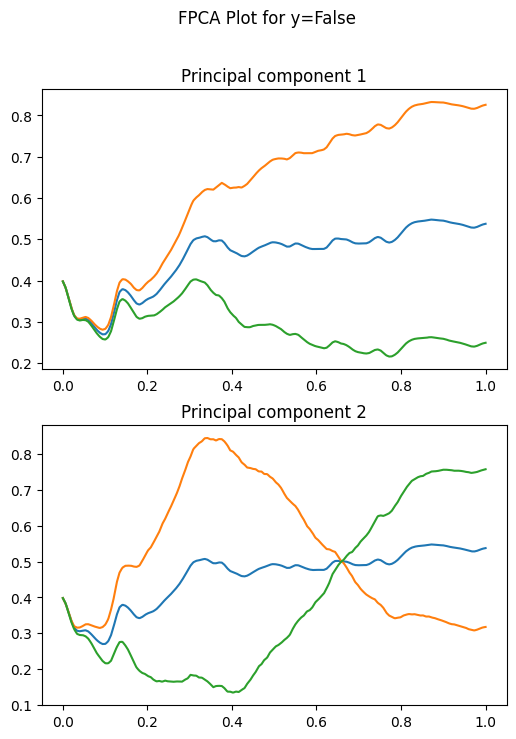

In [11]:
# FPCA plot for y=True
fig = plt.figure(figsize=(6, 2 * 4))
plt.suptitle("FPCA Plot for y=True")
fig_true = FPCAPlot(
    x_opt[y].mean(),          # Sample mean of the data for y=True
    fpca_true.components_,    # Principal components for y=True
    factor=0.2,               # Scale factor for the separation between curves
    fig=fig,
    n_rows=2,
).plot()
plt.title("FPCA Plot for y=True")

# FPCA plot for y=False
fig = plt.figure(figsize=(6, 2 * 4))
plt.suptitle("FPCA Plot for y=False")
fig_false = FPCAPlot(
    x_opt[~y].mean(),         # Sample mean of the data for y=False
    fpca_false.components_,   # Principal components for y=False
    factor=0.2,               # Scale factor for the separation between curves
    fig=fig,
    n_rows=2,
).plot()
plt.show()

si cheating, entonces la media va hacia la victoria rapidamente, si no, se queda en torno al 0 (empate). En particular, si hay cheating, entonces las evals se ponen positivas para el lado que hace trampas, pero si no hay cheating, se dejan las evals por defecto para blancas, que como empieza primero, tiende a ganar mas a menudo (eval se establece entorn al +0.5).

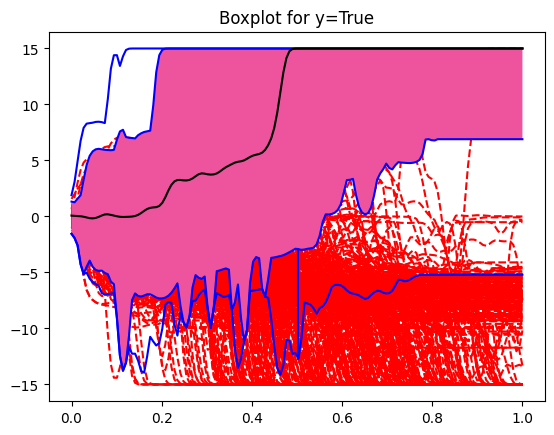

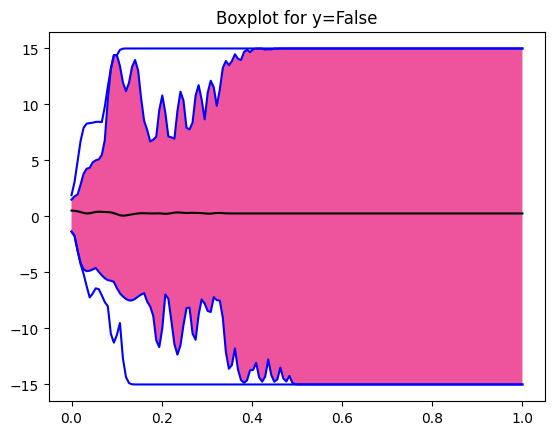

In [15]:
from skfda.exploratory.visualization import Boxplot

# Create boxplots for y=True and y=False
boxplot_true = Boxplot(x_opt[y])
boxplot_false = Boxplot(x_opt[~y])

boxplot_true.plot()
plt.title("Boxplot for y=True")
plt.show()
boxplot_false.plot()
plt.title("Boxplot for y=False")
plt.show()
